In [1]:
from graphviz import Source

In [2]:
class SuffixNode: 
    
    # text often needs to be accessed for printing
    text = None
    
    # number of nodes. necessary for creating new note id-s for printing
    counter = 0
    
    # global end of text for all tree nodes
    # since leaf nodes point at the end of the text we can increment it for all of them at once 
    text_end = 0
    
    def __init__(self,start=-1,end=-1,parent=None, link = None):
        SuffixNode.counter += 1
        self.id = SuffixNode.counter
        
        # starting index of a text represented by the edge
        self.start = start
        # ending index (if ending index exals -1 it means that we should use the global text end index)
        self.end = end
        
        # suffix link
        self.link = link
        
        # self explainatory
        self.parent = parent
        self.children = {}
        
        # for finding a stubstring in text
        self.leaf_index = None
        
        # we update depth for printing tree
        self.depth = 0

    
    # returning the length of an edge
    def edge_length(self):
        if self.end == -1:
            return SuffixNode.text_end - self.start
        return self.end-self.start    
    
    
    
    
    # functions for printing the tree
    
    def dot_node(self):
        return f'{self.id} [label="", shape="point"];'
    
    def dot_edges(self, links = False):
        result = []
        for child in self.children.values():
            if child.start+1 == child.end or child.start + 1 == self.text_end:
                newLabel = SuffixNode.text[child.start]
#                 if child.end == -1:
#                     end = self.text_end
#                 else: end = child.end
#                 newLabel = f'[{child.start}/{end}]'
            else:
                if child.end == -1:
                    end = self.text_end
                else: end = child.end
                newLabel = f'[{child.start}/{end}]'
            result.append(f'{self.id} -> {child.id}[arrowhead="none", label=" {newLabel}"];')
        if self.link and links:
            result.append(f'{self.id} -> {self.link.id}[color="blue"];')
        return "\n".join(result)
    
    def get_all_children(self):
        result = [self]
        for child in self.children.values():
            result += child.get_all_children()
        return result 
    
    def show_tree(self,links = False):
        self.depth_update()
        nodes = self.get_all_children()
        SuffixNode.show_graph(nodes,links)
    
    @staticmethod
    def show_graph(nodes, links = False):
        result = "digraph{\n"
        ranks = {}
        for node in nodes:
            result += node.dot_node() + "\n"
            result += node.dot_edges(links) + "\n"
            if(node.depth not in ranks):
                ranks[node.depth] = []
            ranks[node.depth].append(node.id)
        for key, values in ranks.items():
            values = " ".join([f"{v};" for v in values])
            result += " { rank=same; " + values + "}\n"
        result += "\n}"
        s = Source(result)
        display(s)
    
    def depth_update(self,val = 0):
        self.depth = val
        for child in self.children.values():
            child.depth_update(val+1)

In [3]:
class UkkonenTree:
    def __init__(self,text):
        self.root = SuffixNode()
        self.text = text
        SuffixNode.text = text 
        
        # active variables necessary for linear processing
        self.active_node = self.root 
        self.active_edge = -1 # we store the edge as the index of the first letter on the edge
        self.active_length = 0 # how deep the active point is located on the edge below the active node 
        
        # number of remaining iteration loops. there will be one incrementation for each suffix
        self.to_process = 0
        
        # the loop processing all suffixes
        for i in range(len(text)):
            self.extend_tree(i)
            
        self.set_index(self.root)
        
        
    # walkdown function for updating active point if it ends up reaching the child node
    def walk_down(self):
        
        if self.text[self.active_edge] not in self.active_node.children.keys(): # If I'm correct, this never happens
            return 0
        elif self.active_length >= self.active_node.children[self.text[self.active_edge]].edge_length():
            if self.active_node.children[self.text[self.active_edge]].end == -1: return 0
            self.active_node = self.active_node.children[self.text[self.active_edge]]
            self.active_edge += self.active_node.edge_length() # bez +1 bo indeksujemy informatycznie
            self.active_length -= self.active_node.edge_length()
            return 1
        else: return 0

    
    # tree extention for suffix of length i
    def extend_tree(self, i):

        # incrementing the global text ending index for all leaf nodes
        SuffixNode.text_end = i +1

        # incrementing the number of remaining loops 
        self.to_process += 1
        
        # reseting a newest node variable for this extension
        newest_node = None

        while self.to_process > 0:
            
            # if there are no active edges going out of this node we have to update it to the current letter
            if self.active_length == 0:
                self.active_edge = i

            # create a new edge from active node if active length is 0 and there's no edge with the processed character 
            if self.text[i] not in self.active_node.children.keys() and self.active_length == 0:
                self.active_node.children[self.text[i]] = SuffixNode(i,-1,parent = self.active_node)

                if newest_node is not None:
                    newest_node.link = self.active_node
                    newest_node = None
            else:
                if self.walk_down() == 1: 
                    continue # if we walk down, we have to process the beginning of the loop again
                
                # we need to get the information about the edge
                child = self.active_node.children[self.text[self.active_edge]]

                # if processed suffix of a prefix is already in the tree implicitly we break the iteration early
                # we can do that because the last unique character will always force the algorithm to create them explicitly
                if self.text[child.start + self.active_length] == self.text[i]: 
                    if newest_node is not None and self.active_node != self.root:
                        newest_node.link = self.active_node
                        newest_node = None
                    self.active_length += 1
                    break
                
                # otherwise we have to break the path (create a new node on the existing edge)
                
                new_end = child.start + self.active_length
                new_node = SuffixNode(child.start, new_end, parent = self.active_node, link = self.root)
                self.active_node.children[self.text[self.active_edge]] = new_node
                new_node.children[self.text[child.start + self.active_length]] = child
                child.parent = new_node
                child.start = new_end
                new_node.children[self.text[i]] = SuffixNode(i,-1,parent = new_node)
                

                if newest_node is not None:
                    newest_node.link = new_node

                newest_node = new_node

            # we decrement the remaining number of iterations
            self.to_process -= 1

            if self.active_node == self.root and self.active_length > 0:
                self.active_length -= 1
                self.active_edge = i - self.to_process + 1

            # active node update with suffix link
            elif self.active_node != self.root:
                self.active_node = self.active_node.link
                    
    def set_index(self, node, d = 0):  
        if len(node.children) == 0:
            node.leaf_index = len(self.text) - d
            return
        else:
            for child in node.children.values():
                self.set_index(child,d + child.edge_length())

                
    
    def find_string(self,pattern): 
        result = []

        # the depth-first search recursive function that finds every leaf in a subtree and adds it to the resulting set
        def dfs(node):
            if len(node.children) == 0:
                result.append(node.leaf_index)
            else:
                for child in node.children.values():
                    dfs(child)

        # we'll descend down the tree following the letters in the pattern
        node = self.root
        # i will define our letters
        i = 0

        while True:
            # of course we can only descent from the node if it has a child matching the lettern from our string
            if pattern[i] in node.children.keys():
                child = node.children[pattern[i]]

                # we'll have to move the considered node to the position of it's child
                # this will happen only if the remaining length of our string is greater than the one represented by the edge
                if len(pattern[i:]) > child.end-child.start:
                    # to go further, those parts must be identical
                    if pattern[i:i+child.end-child.start] == self.text[child.start:child.end]:
                        node = child
                        i = child.end
                    # otherwise it will mean that there are no such patterns appearing in the text 
                    else: return result 

                # if our remaining length of the pattern is smaller than the edge's, 
                # we have to compare the piece of the same length
                elif pattern[i:] == self.text[child.start:child.start+len(pattern)-i]:
                    dfs(child)
                    return result
                else: return result
            else: return result
            
    def show_tree(self,links = False):
        self.root.show_tree(links)

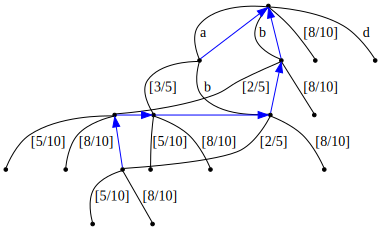

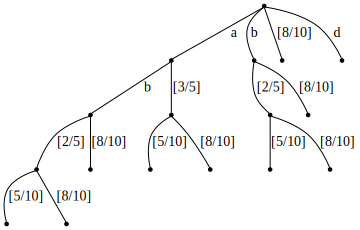

In [4]:
text2 = "abaabaabcd"
tree2 = UkkonenTree(text2)
tree2.show_tree(links = True)
tree2.show_tree()

In [5]:
tree2.find_string("abaab")

[0, 3]